### Gaussian Copula MLE
create matricies for 

have 2 codes: one with gaussian, one with vtransform, both taking multiple days, both being copulas( ie divide buy marginals) once this is running, fit it on aust data with only the loc distance matrix 

work on getting a dist matrix for predictors

most important is vcopula ready with different days, and fit on aust data - first only with location matrix

In [1]:
from scipy.optimize import dual_annealing
import numpy as np
import itertools
from scipy.optimize import Bounds
from scipy.optimize import minimize
import scipy.stats as scs
from pynverse import inversefunc
from math import sqrt
from scipy.special import gamma
from scipy.special import kv 
from  geopy.geocoders import Nominatim
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern


In [ ]:
class mvnorm():

    def __init__(self,mean=[0,0,0],L=np.array([[0,1,1],[1,0,1],[1,1,0]]),X=np.array([[0,2,3],[2,0,4],[3,4,0]])):
        self.mean=mean
        self.N=L.shape[0]
        self.L=L
        self.X=X
    def sim(self,sigma,p0,v0,p1,v1,n=10):
        cov_mat=Matern(length_scale=p0,nu=v0).__call__(self.L)* Matern(length_scale=p1,nu=v1).__call__(self.L) *np.power(sigma,2) 
        return [scs.multivariate_normal.rvs(mean=self.mean,cov=cov_mat) for i in range(n)]
    
    def nll(self,theta,data):
        #data is an array with multiple sets of joint realistaions
        #theta=[sigma,p0,v0,p1,v1]
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L)* Matern(length_scale=theta[3],nu=theta[4]).__call__(self.L) *np.power(theta[0],2)      
        #and  theta[indexes]
        nll=0
        for obs in data:
            nll+= scs.multivariate_normal.logpdf(obs,mean=self.mean,cov=cov_mat) 
        return -nll

    #taking multiple days
    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]]),X=[np.array([[0,2,3],[2,0,4],[3,4,0]])]):
        '''
        L is location matrix: n x n
        X is predictor matrix, day dependent: [mat_1 , mat_2 , ..] m times n x n 
        '''
        self.N=L.shape[0]
        self.L=L
        self.X_all=X

    def sim(self,theta,n=10):
        cov_mat_all=[Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L)* Matern(length_scale=theta[3],nu=theta[4]).__call__(X_current) *np.power(theta[0],2) for X_current in self.X_all] 
        return [scs.multivariate_normal.rvs(mean=self.mean,cov=cov_mat) for i in range(n)]
    
    def nll(self,theta,data):
        #data is an array with multiple sets of joint realistaions
        #theta=[sigma,p0,v0,p1,v1]
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L)* Matern(length_scale=theta[3],nu=theta[4]).__call__(self.L) *np.power(theta[0],2)      
        #and  theta[indexes]
        nll=0
        for obs in data:
            nll+= scs.multivariate_normal.logpdf(obs,mean=self.mean,cov=cov_mat) 
        return -nll

In [3]:
# sim and nll work, but not correct nll    
class norm_cop():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]]),X=[np.array([[0,2,3],[2,0,4],[3,4,0]])]):
        '''
        L is location matrix: n x n
        X is predictor matrix, day dependent: [mat_1 , mat_2 , .., mat_days] days times n x n 
        '''
        self.N=L.shape[0]
        self.L=L
        self.X_all=X
        self.T=len(X)

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat_all=[Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L)* Matern(length_scale=theta[3],nu=theta[4]).__call__(X_current) *np.power(theta[0],2) for X_current in self.X_all] 
        if as_x==True:
            return [[scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] for cov_mat in cov_mat_all ]
        if as_x==False:
            Us=[[np.zeros(self.N) for i in range(draws)] for cov_mat in cov_mat_all ]
            for day,cov_mat in enumerate(cov_mat_all):
                for i in range(draws):
                    Us[day][i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data,test_sim=False):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        for day in range(self.T):
            #covariance matrix
            cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L)* Matern(length_scale=theta[3],nu=theta[4]).__call__(self.X_all[day]) *np.power(theta[0],2) 
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll
        
        

In [24]:
#checking if sim and nll work:
test_data=norm_cop(X=[np.array([[0,2,3],[2,0,i+1],[3,i+1,0]]) for i in range(1)]).sim([1,2,3,4,5],draws=2000,as_x=False)[0]
norm_cop(X=[np.array([[0,2,3],[2,0,i+1],[3,i+1,0]]) for i in range(1)]).nll([1,2,3,4,5],test_data)

-0.5010957601299642

### Heatmaps of density for different parameters

In [158]:
#sim and nll work
#now try plotting heatmap
#optimisation
#matrix for predictors

In [43]:
data=norm_cop(X=[np.array([[0,2,3],[2,0,i+1],[3,i+1,0]]) for i in range(1)]).sim([1,2,3,4,5],draws=20,as_x=False)[0]

x_val=np.linspace(0.1, 8, 90)
y_val=np.linspace(0.1 ,8, 90)
X,Y =np.meshgrid(x_val,y_val)
Z=np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j]=norm_cop(X=[np.array([[0,2,3],[2,0,i+1],[3,i+1,0]]) for i in range(1)]).nll([1,2,3,X[i,j],Y[i,j]],test_data)
        


C:\Users\david\AppData\Local\Temp\ipykernel_8060\2767479480.py:1: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(X,Y,-Z,100,color='viridis')


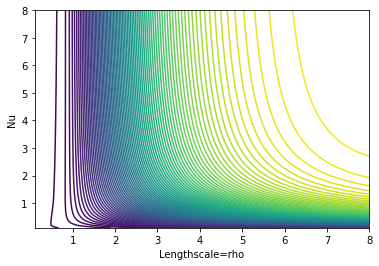

In [44]:

plt.contour(X,Y,-Z,100,color='viridis')
plt.xlabel('Lengthscale=rho')
plt.ylabel('Nu')
plt.show()

### Gaussian copula with only location matrix ie: a single kernel

In [65]:
#makes the banana density region shift with sigma=1!
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2)  
        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2) 

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll
        

In [66]:
#it can simulate and evalue the nll
data2=norm_cop_loconly().sim([1,2,3],draws=3,as_x=False)
norm_cop_loconly().nll([1,2,3],data2)

-0.7683933081627985

In [100]:
#works with sigma=1, approximately well: banana shape shifts to the right place.
data=norm_cop_loconly().sim([1,8,3],draws=20,as_x=False)

x_loconly=np.linspace(1, 9, 50)
y_loconly=np.linspace(0.1 ,7, 50)
Xloc,Yloc =np.meshgrid(x_loconly,y_loconly)
Zloc=np.zeros(Xloc.shape)
for i in range(Zloc.shape[0]):
    for j in range(Zloc.shape[1]):
        Zloc[i,j]=norm_cop_loconly().nll([1,Xloc[i,j],Yloc[i,j]],data)
        


Locator attempting to generate 1821 ticks ([-3.75, ..., 50.85]), which exceeds Locator.MAXTICKS (1000).
C:\Users\david\AppData\Local\Temp\ipykernel_8060\282506337.py:1: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Xloc,Yloc,-Zloc,2000,color='viridis')


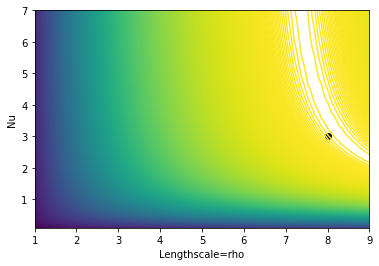

In [107]:
plt.contour(Xloc,Yloc,-Zloc,2000,color='viridis')
plt.scatter(8,3,color='black')
plt.xlabel('Lengthscale=rho')
plt.ylabel('Nu')
plt.show()